In [120]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [152]:
symbol = 'SOL-USD'
data = yf.download(symbol, period='max')

C:\Users\Göktürk\AppData\Local\Temp\ipykernel_8840\1541330783.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period='max')
[*********************100%***********************]  1 of 1 completed


In [153]:
short_window = 10
long_window = 50
data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

### Creating signals

In [154]:
data['Signal'] = 0
data.loc[data.index[short_window:], 'Signal'] = np.where(
    data['Short_MA'][short_window:] > data['Long_MA'][short_window:], 1, 0)
data['Position'] = data['Signal'].diff()

### Stimulating trades

In [155]:
leverage = 1
taker_fee = 0.0004  # 0.04%
initial_cash = 100
data['Returns'] = data['Close'].pct_change()
data['Leveraged_Returns'] = data['Returns'] * leverage
data['Fees'] = data['Position'].abs() * taker_fee * leverage  # Fees on entry/exit
data['Strategy_Returns'] = (data['Leveraged_Returns'] * data['Signal'].shift(1)) - data['Fees']
data['Portfolio_Value'] = initial_cash * (1 + data['Strategy_Returns']).cumprod()

### Calculating the metrics

In [156]:
total_return = (data['Portfolio_Value'].iloc[-1] / initial_cash) - 1
sharpe_ratio = (data['Strategy_Returns'].mean() / data['Strategy_Returns'].std()) * np.sqrt(365)
max_drawdown = (data['Portfolio_Value'].cummax() - data['Portfolio_Value']).max() / data['Portfolio_Value'].cummax().max()

print(f"Total Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

Total Return: 77707.39%
Sharpe Ratio: 1.76
Max Drawdown: 53.19%


### Plotting the stimulated trades & returns

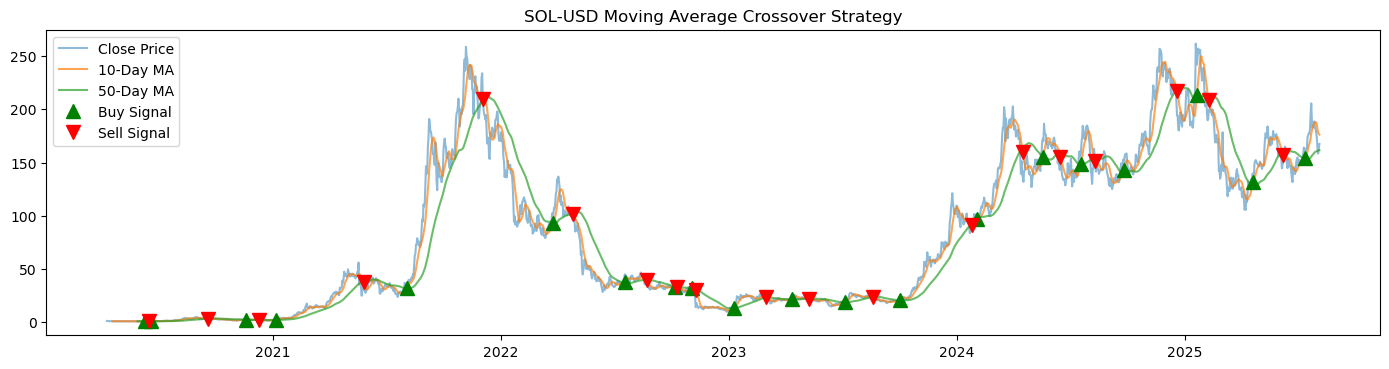

In [157]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['Short_MA'], label=f'{short_window}-Day MA', alpha=0.7)
plt.plot(data['Long_MA'], label=f'{long_window}-Day MA', alpha=0.7)
plt.plot(data[data['Position'] == 1].index, data['Short_MA'][data['Position'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(data[data['Position'] == -1].index, data['Short_MA'][data['Position'] == -1], 'v', markersize=10, color='r', label='Sell Signal')
plt.title(f'{symbol} Moving Average Crossover Strategy')
plt.legend()

plt.tight_layout()
plt.show()

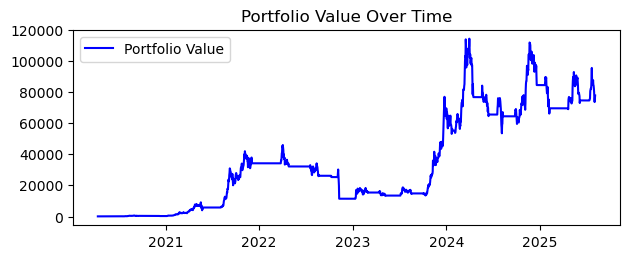

In [158]:
plt.subplot(2, 1, 2)
plt.plot(data['Portfolio_Value'], label='Portfolio Value', color='b')
plt.title('Portfolio Value Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [159]:
data.tail()

Price,Close,High,Low,Open,Volume,Short_MA,Long_MA,Signal,Position,Returns,Leveraged_Returns,Fees,Strategy_Returns,Portfolio_Value
Ticker,SOL-USD,SOL-USD,SOL-USD,SOL-USD,SOL-USD,,,,,,,,,
Date,,,,,,,,,,,,,,
2025-07-30,177.694016,182.379517,172.342270,181.335312,6074764559,187.584174,160.534116,1,0.0,-0.020080,-0.020080,0.0,-0.020080,82527.573599
2025-07-31,172.424347,182.482483,171.852798,177.693787,5443530167,185.227182,160.761486,1,0.0,-0.029656,-0.029656,0.0,-0.029656,80080.147554
2025-08-01,162.877090,172.417114,159.788574,172.417114,8200357157,180.944836,160.963234,1,0.0,-0.055371,-0.055371,0.0,-0.055371,75646.053875
2025-08-02,158.483017,165.107010,156.084351,162.877090,4455060056,177.838844,161.160327,1,0.0,-0.026978,-0.026978,0.0,-0.026978,73605.286086
2025-08-04,167.530762,169.607880,161.473877,161.962280,4955290112,176.331314,161.615668,1,0.0,0.057090,0.057090,0.0,0.057090,77807.388328


### Final Verdict: 
#### Since the Sharpe ratio is unusually high even with a leverage of 1, it suggests that the strategy is likely overfitted and may not perform well in real market conditions. Adjusting the SMA window sizes might help achieve more realistic and robust results.

### Disclaimer

#### This project is intended for educational purposes only. It does not constitute financial advice or a recommendation to buy or sell any financial instrument. Past performance is not indicative of future results. Always do your own research or consult with a licensed financial advisor before making investment decisions.